In [1]:
SEED_NUMBER = 1234
from numpy.random import seed
from tensorflow.compat.v1 import set_random_seed
seed(SEED_NUMBER)
set_random_seed(SEED_NUMBER)

import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

import shutil
import pathlib
import tempfile

LOGDIR = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(LOGDIR, ignore_errors=True)

pd.options.display.max_columns=500
pd.options.display.max_rows=500

# load preprocessed datasets
train = pd.read_csv('./data/processed/train_processed.csv')  
test = pd.read_csv('./data/processed/test_processed.csv') 

#### Preprocess: 
See task/process_data.py and Data Processing README.rmd for detailed documentation.
- remove outliers
- impute missing values
- add new features
- dummify categorical features
- bucketize numeric features and dummified

In [2]:
print(train.shape)
print(train.isnull().sum().sum()) # check for no missing value
train.head() # visually inspect dataset. 

(1456, 258)
0


,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,IsPool,IsGarage,IsFireplace,TotalFullBath,TotalHalfBath,TotalSF,IsOpenPorch,YrBuilt_1929,YrBuilt_1954,YrBuilt_1963,YrBuilt_1973,YrBuilt_1990,YrBuilt_2000,YrBuilt_2005,YrBuilt_2009,YrRemodAdd_1929,YrRemodAdd_1954,YrRemodAdd_1963,YrRemodAdd_1973,YrRemodAdd_1990,YrRemodAdd_2000,YrRemodAdd_2005,YrRemodAdd_2009,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Condition1_Norm,Condition1_Other,LotShape_Artery,LotShape_Feedr,LotShape_Norm,LotShape_PosA,LotShape_PosN,LotShape_RRAe,LotShape_RRAn,LotShape_RRNn,Functional_IReg,Functional_Reg,Electrical_N,RoofMatl_Other,RoofMatl_SBrkr,RoofStyle_CompShg,RoofStyle_Other,Heating_Gable,Heating_Hip,Heating_Other,Foundation_GasA,Foundation_Other,SaleType_BrkTil,SaleType_CBlock,SaleType_Other,SaleType_PConc,LandContour_COD,LandContour_New,LandContour_Other,LandContour_WD,MSZoning_Bnk,MSZoning_HLS,MSZoning_Low,MSZoning_Lvl,Street_C (all),Street_FV,Street_RH,Street_RL,Street_RM,Alley_Grvl,Alley_Pave,HouseStyle_Grvl,HouseStyle_None,HouseStyle_Pave,BldgType_1.5Fin,BldgType_1.5Unf,BldgType_1Story,BldgType_2.5Fin,BldgType_2.5Unf,BldgType_2Story,BldgType_SFoyer,BldgType_SLvl,LandSlope_1Fam,LandSlope_2fmCon,LandSlope_Duplex,LandSlope_Twnhs,LandSlope_TwnhsE,LotConfig_Gtl,LotConfig_Mod,LotConfig_Sev,Neighborhood_Corner,Neighborhood_CulDSac,Neighborhood_FR2,Neighborhood_FR3,Neighborhood_Inside,GarageType_Blmngtn,GarageType_Blueste,GarageType_BrDale,GarageType_BrkSide,GarageType_ClearCr,GarageType_CollgCr,GarageType_Crawfor,GarageType_Edwards,GarageType_Gilbert,GarageType_IDOTRR,GarageType_MeadowV,GarageType_Mitchel,GarageType_NAmes,GarageType_NPkVill,GarageType_NWAmes,GarageType_NoRidge,GarageType_NridgHt,GarageType_OldTown,GarageType_SWISU,GarageType_Sawyer,GarageType_SawyerW,GarageType_Somerst,GarageType_StoneBr,GarageType_Timber,GarageType_Veenker,PavedDrive_2Types,PavedDrive_Attchd,PavedDrive_Basment,PavedDrive_BuiltIn,PavedDrive_CarPort,PavedDrive_Detchd,PavedDrive_None,Fence_N,Fence_P,Fence_Y,MasVnrType_GdPrv,MasVnrType_GdWo,MasVnrType_MnPrv,MasVnrType_MnWw,MasVnrType_None,CentralAir_BrkCmn,CentralAir_BrkFace,CentralAir_None,CentralAir_Stone,SaleCondition_N,SaleCondition_Y,BsmtExposure_Abnorml,BsmtExposure_AdjLand,BsmtExposure_Alloca,BsmtExposure_Family,BsmtExposure_Normal,BsmtExposure_Partial,Condition2_Av,Condition2_Gd,Condition2_Mn,Condition2_No,Condition2_None,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,65.0,8450,7,5,196.0,8,6,8,6,10,706,0,150,856,10,856,854,0,1710,1,0,2,1,3,1,8,8,0,0,2003.0,4,2,548,6,6,0,61,0,0,0,0,0,208500,0,1,1,3,1,2566,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

<b>Train test split

In [3]:
np.random.seed(SEED_NUMBER)
msk = np.random.rand(train.shape[0]) < 0.75
traindf = train[msk]
testdf = train[~msk]
train_labels = traindf.pop('SalePrice')
test_labels = testdf.pop('SalePrice')
print(f'training shape: {traindf.shape} and test shape: {testdf.shape}')

training shape: (1081, 257) and test shape: (375, 257)


<b> Standard Scaler</b>
<br>
Scaling numeric features helps with model in general.
This is proven to improve neural networks model performance.

In [4]:
# numeric columns where values range beyond -1 to 1.
SCALE_COLS = ['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'GarageYrBlt', 'OpenPorchSF', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'TotalFullBath', 'TotalHalfBath', 'TotalSF', 'HeatingQC','BsmtFinType1']


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # default : copy=True, with_mean=True, with_std=True
scaler.fit(traindf[SCALE_COLS]) # we can save scaler if need to be reused in the future or build it into our data preprocessing pipeline.

# transform
traindf_s = pd.DataFrame(scaler.transform(traindf[SCALE_COLS]), columns = SCALE_COLS)
traindf_s = pd.concat([traindf.drop(columns=SCALE_COLS).reset_index(drop=True),traindf_s],axis=1)
testdf_s = pd.DataFrame(scaler.transform(testdf[SCALE_COLS]), columns = SCALE_COLS)
testdf_s = pd.concat([testdf.drop(columns=SCALE_COLS).reset_index(drop=True),testdf_s], axis=1)

# final testset for kaggle submission
test_s = pd.DataFrame(scaler.transform(test[SCALE_COLS]), columns = SCALE_COLS)
test_s = pd.concat([test.drop(columns=SCALE_COLS).reset_index(drop=True),test_s], axis=1)

print(f'training shape: {traindf_s.shape} and test shape: {testdf.shape}')
testdf_s.head() # check that scaler worked.

training shape: (1081, 257) and test shape: (375, 257)


,IsPool,IsGarage,IsFireplace,IsOpenPorch,YrBuilt_1929,YrBuilt_1954,YrBuilt_1963,YrBuilt_1973,YrBuilt_1990,YrBuilt_2000,YrBuilt_2005,YrBuilt_2009,YrRemodAdd_1929,YrRemodAdd_1954,YrRemodAdd_1963,YrRemodAdd_1973,YrRemodAdd_1990,YrRemodAdd_2000,YrRemodAdd_2005,YrRemodAdd_2009,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Condition1_Norm,Condition1_Other,LotShape_Artery,LotShape_Feedr,LotShape_Norm,LotShape_PosA,LotShape_PosN,LotShape_RRAe,LotShape_RRAn,LotShape_RRNn,Functional_IReg,Functional_Reg,Electrical_N,RoofMatl_Other,RoofMatl_SBrkr,RoofStyle_CompShg,RoofStyle_Other,Heating_Gable,Heating_Hip,Heating_Other,Foundation_GasA,Foundation_Other,SaleType_BrkTil,SaleType_CBlock,SaleType_Other,SaleType_PConc,LandContour_COD,LandContour_New,LandContour_Other,LandContour_WD,MSZoning_Bnk,MSZoning_HLS,MSZoning_Low,MSZoning_Lvl,Street_C (all),Street_FV,Street_RH,Street_RL,Street_RM,Alley_Grvl,Alley_Pave,HouseStyle_Grvl,HouseStyle_None,HouseStyle_Pave,BldgType_1.5Fin,BldgType_1.5Unf,BldgType_1Story,BldgType_2.5Fin,BldgType_2.5Unf,BldgType_2Story,BldgType_SFoyer,BldgType_SLvl,LandSlope_1Fam,LandSlope_2fmCon,LandSlope_Duplex,LandSlope_Twnhs,LandSlope_TwnhsE,LotConfig_Gtl,LotConfig_Mod,LotConfig_Sev,Neighborhood_Corner,Neighborhood_CulDSac,Neighborhood_FR2,Neighborhood_FR3,Neighborhood_Inside,GarageType_Blmngtn,GarageType_Blueste,GarageType_BrDale,GarageType_BrkSide,GarageType_ClearCr,GarageType_CollgCr,GarageType_Crawfor,GarageType_Edwards,GarageType_Gilbert,GarageType_IDOTRR,GarageType_MeadowV,GarageType_Mitchel,GarageType_NAmes,GarageType_NPkVill,GarageType_NWAmes,GarageType_NoRidge,GarageType_NridgHt,GarageType_OldTown,GarageType_SWISU,GarageType_Sawyer,GarageType_SawyerW,GarageType_Somerst,GarageType_StoneBr,GarageType_Timber,GarageType_Veenker,PavedDrive_2Types,PavedDrive_Attchd,PavedDrive_Basment,PavedDrive_BuiltIn,PavedDrive_CarPort,PavedDrive_Detchd,PavedDrive_None,Fence_N,Fence_P,Fence_Y,MasVnrType_GdPrv,MasVnrType_GdWo,MasVnrType_MnPrv,MasVnrType_MnWw,MasVnrType_None,CentralAir_BrkCmn,CentralAir_BrkFace,CentralAir_None,CentralAir_Stone,SaleCondition_N,SaleCondition_Y,BsmtExposure_Abnorml,BsmtExposure_AdjLand,BsmtExposure_Alloca,BsmtExposure_Family,BsmtExposure_Normal,BsmtExposure_Partial,Condition2_Av,Condition2_Gd,Condition2_Mn,Condition2_No,Condition2_None,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,GarageYrBlt,OpenPorchSF,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalFullBath,TotalHalfBath,TotalSF,HeatingQC,BsmtFinType1
0,0,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

<b>Benchmark model</b>
<br>Establishing a simple linear model with L1 regularization as our benchmark model to compare our neural net models against.

In [5]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
for a in [0.00003, 0.0003, 0.003, 0.03, 0.3, 3, 33, 333, 3333, 33333]:
    linear_estimator = Lasso(alpha = a)
    score = cross_val_score(linear_estimator, traindf_s, train_labels, \
                            scoring= 'neg_root_mean_squared_error', cv = 3) # 3 fold cross validation 
    print(f'Alpha: {a}  --- mean RMSE: {round(np.mean(-score),4)} std: {round(np.std(-score),4)}')

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194691919114.07233, tolerance: 456776741.04088
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183201861464.2257, tolerance: 439111172.3405994
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189441989940.4667, tolerance: 428250184.11820865
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did 

Alpha: 3e-05  --- mean RMSE: 31709.3835 std: 1356.3262
Alpha: 0.0003  --- mean RMSE: 31709.8354 std: 1356.7409


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183186025291.32217, tolerance: 439111172.3405994
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189407217171.74536, tolerance: 428250184.11820865
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194448284884.31155, tolerance: 456776741.04088
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective di

Alpha: 0.003  --- mean RMSE: 31714.938 std: 1361.7529
Alpha: 0.03  --- mean RMSE: 31767.1137 std: 1417.4161


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170582349382.21222, tolerance: 456776741.04088
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164969422053.10562, tolerance: 439111172.3405994
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153250415392.80536, tolerance: 428250184.11820865
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective di

Alpha: 0.3  --- mean RMSE: 31728.4856 std: 1383.6079
Alpha: 3  --- mean RMSE: 31237.2559 std: 973.2761


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56391862118.00305, tolerance: 439111172.3405994
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59191555985.85486, tolerance: 428250184.11820865
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3202099888.1324463, tolerance: 456776741.04088
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did 

Alpha: 33  --- mean RMSE: 30315.0685 std: 659.414
Alpha: 333  --- mean RMSE: 28814.0156 std: 1339.0096
Alpha: 3333  --- mean RMSE: 29941.8992 std: 1910.5316
Alpha: 33333  --- mean RMSE: 50894.6563 std: 2349.7919


/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6530617354.721619, tolerance: 428250184.11820865
  positive)


<b> Benchmark model: LASSO w/ alpha = 333. </b>
- Cross Valiation mean RMSE: 28814.0156 std: 1007.3058 <br>
- this is a big penalization for large coefficients. Let's see how the lasso model performs on our test dataset.

In [6]:
def test_rmse(test_predictions):
# Generate mean test error rmse.
    rmse = np.mean(np.sqrt((test_labels - test_predictions)**2))
    return rmse

In [7]:
test_rmses={} # record test rmse scores
training_times={}

In [8]:
linear_estimator = Lasso(alpha = 333)
start_time = time.time()
linear_estimator.fit(traindf_s, train_labels)
training_time = time.time() - start_time
print(f'TRAIN TIME: {training_time} seconds \n')
training_times['lasso'] = training_time
rmse = test_rmse(linear_estimator.predict(testdf_s))
print('*'*5 + f' Test RMSE: {rmse} '+ '*'*5)
test_rmses['lasso'] = rmse

TRAIN TIME: 0.02143096923828125 seconds 

***** Test RMSE: 20431.374067946865 *****


## Neural Network - Keras

Starting from the simplest, let's start with basic nn with only 1 hidden unit.
<br>
X --> 257 (Relu) --> Y, dim(X) = [1081, 257]
<br>
optimizers: 
- keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
- keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

EPOCHS = 2000

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2) # plotting training progress history

In [10]:
def simple_model(optimizer = keras.optimizers.RMSprop(0.01), dropout=False, rate = 0.1):
    
# build a basic neural net model: X--> 257 --> Y
#     input: 
#         optimizer: keras optimizer. default: RMSprop
#         dropout: True or False
#         rate: dropout rate. ranges between 0 and 1. default is 0.1
#     output:
#         basic neural net model.
    
    set_random_seed(SEED_NUMBER) # reproducibility
    
    model = keras.Sequential()
    model.add(layers.Dense(len(traindf_s.keys()), activation='relu', input_shape=[len(traindf_s.keys())]))
    if dropout:
        model.add(layers.Dropout(rate, seed = SEED_NUMBER))
    model.add(layers.Dense(1))
    
    model.summary()
    
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    return model

In [11]:
model = simple_model()
set_random_seed(SEED_NUMBER) # reproducibility
start_time = time.time()

# train model
history = model.fit(traindf_s, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, 
                    verbose=0, shuffle = False,
                    callbacks=[tfdocs.modeling.EpochDots()])
training_time = time.time()-start_time
training_times['simple_wo_early_stopping'] = training_time
print('\n')
print('TRAIN TIME:'+f'{round(training_time)} seconds \n')
hist = pd.DataFrame(history.history) # training history
hist['epoch'] = history.epoch
hist.tail() # check last few epoch training data.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 257)               66306     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 258       
Total params: 66,564
Trainable params: 66,564
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:37550431725.0370,  root_mean_squared_error:193779.3438,  val_loss:41121499220.9401,  val_root_mean_squared_error:202784.3750,  
....................................................................................................
Epoch: 100, loss:534764861.0370,  root_mean_squared_error:23124.9844,  val_loss:1268635069.9355,  val_root_mean_squared_error:35617.9023,  
....................................................................................................
Epoch: 200, loss:416251282.9

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,epoch
1995,1.156432e+08,10753.753906,1.111744e+09,33342.820312,1995
1996,1.155352e+08,10748.730469,1.111819e+09,33343.949219,1996
1997,1.154173e+08,10743.246094,1.112091e+09,33348.035156,1997
1998,1.152910e+08,10737.366211,1.111873e+09,33344.753906,1998
1999,1.151633e+08,10731.416016,1.111889e+09,33345.003906,1999


Text(0, 0.5, 'RMSE')

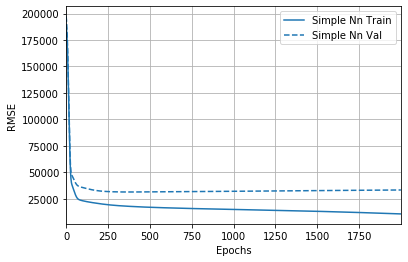

In [12]:
plotter.plot({'Simple NN': history}, metric = "root_mean_squared_error")
plt.ylabel('RMSE')

In [13]:
test_predictions = model.predict(testdf_s).flatten() # predict on test set
rmse = test_rmse(test_predictions) 
print('*'*5 + f' Test RMSE: {rmse} '+ '*'*5) # print test set rmse.
test_rmses['simple'] = rmse 

***** Test RMSE: 18645.862395833334 *****


As you see from above, simple neural net is already performing better than the fine tuned lasso model.
However, the validation error is not decreasing while training error is.
<br>
Training 2000 epochs takes a lot of time especially if we have more data and it is not necessarily beneficial.
we can either tweak number of epoches or use early stopping.
Let's try using early stopping to stop training when validation error stops decreasing.

### Adding Early Stopping

X --> 257 (Relu) --> Y

In [14]:
def model_fit(model, name, patience = 10, batchsize = 32):
    # The patience parameter is the amount of epochs to check for improvement
    
    set_random_seed(SEED_NUMBER) # reproducibility
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    start_time = time.time()
    # fit
    history = model.fit(traindf_s, train_labels, shuffle = False, 
                        epochs=EPOCHS, validation_split = 0.2, 
                        verbose=0, batch_size = batchsize, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots(), 
                                   keras.callbacks.TensorBoard(LOGDIR/name)])
    training_time = time.time()-start_time
    print('\n')
    print('TRAIN TIME:'+f'{round(training_time)}'+' seconds \n')
    
    return (training_time, history)
    

In [15]:
model_histories = {} # save model histories.
final_predictions = {}

In [16]:
model = simple_model()
training_time, history = model_fit(model, 'sizes/simple')
training_times['simple'] = training_time
model_histories['simple'] = history

test_predictions = model.predict(testdf_s).flatten() # predict on test set
rmse = test_rmse(test_predictions) 
test_rmses['simple'] = rmse
print('\n')
print('*'*5 + f' Test RMSE: {rmse} '+ '*'*5)

final_pred = model.predict(test_s).flatten()
final_predictions['simple'] = final_pred

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 257)               66306     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 258       
Total params: 66,564
Trainable params: 66,564
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:37550431725.0370,  root_mean_squared_error:193779.3438,  val_loss:41121497578.7650,  val_root_mean_squared_error:202784.3750,  
....................................................................................................
Epoch: 100, loss:534764861.0370,  root_mean_squared_error:23124.9844,  val_loss:1268635045.1613,  val_root_mean_squared_error:35617.9023,  
....................................................................................................
Epoch: 200, loss:416251282

- So adding early stopping help our model train fast and also improved our result in the test set.

### Learning rate
let's try other learning rate to see if see if we can furture improve basic neural net

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 257)               66306     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 258       
Total params: 66,564
Trainable params: 66,564
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:37649445774.2222,  root_mean_squared_error:194034.6562,  val_loss:41393988508.9032,  val_root_mean_squared_error:203455.1250,  
....................................................................................................
Epoch: 100, loss:28810274664.2963,  root_mean_squared_error:169735.8906,  val_loss:31864167749.6037,  val_root_mean_squared_error:178505.3750,  
....................................................................................................
Epoch: 200, loss:1090


Epoch: 0, loss:27165165909.3333,  root_mean_squared_error:164818.5938,  val_loss:15744885189.0138,  val_root_mean_squared_error:125478.6250,  
.................................................

TRAIN TIME:6 seconds 



***** Test RMSE: 17295.994208333334 *****


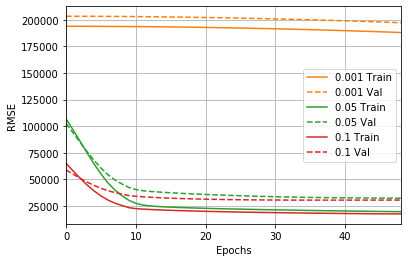

In [17]:
for lr in [0.001, 0.05, 0.1]:
    model = simple_model(optimizer = keras.optimizers.RMSprop(lr))
    training_time, history = model_fit(model, f'lr/simple_rmsprop_lr{str(lr)}')
    
    plotter.plot({str(lr): history}, metric = "root_mean_squared_error")
    plt.ylabel('RMSE')
    
    # predict
    test_predictions = model.predict(testdf_s).flatten()
    rmse = test_rmse(test_predictions) # print test set rmse.
    print('\n')
    print('*'*5 + f' Test RMSE: {rmse} '+ '*'*5)
    
    final_pred = model.predict(test_s).flatten()
    final_predictions['simple_rmsprop_lr_'+str(lr)] = final_pred

- 0.001 converges too slow and training takes very long
- 0.05 and 0.1 are not as good as Keras default learning rate 0.01 for our dataset.
<br> Let's try another popular optimizer, Adam

<b>Adam optimizer</b>

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 257)               66306     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 258       
Total params: 66,564
Trainable params: 66,564
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:37650378676.1481,  root_mean_squared_error:194037.0625,  val_loss:41395652617.4378,  val_root_mean_squared_error:203459.2188,  
....................................................................................................
Epoch: 100, loss:21902414810.0741,  root_mean_squared_error:147994.6406,  val_loss:24368685905.4009,  val_root_mean_squared_error:156104.7344,  
....................................................................................................
Epoch: 200, loss:5665


Epoch: 0, loss:36962758428.4444,  root_mean_squared_error:192257.0156,  val_loss:38578192185.8064,  val_root_mean_squared_error:196413.3125,  
....................................................................................................
Epoch: 100, loss:283195631.4074,  root_mean_squared_error:16828.4180,  val_loss:954310171.7235,  val_root_mean_squared_error:30891.9102,  
...................................

TRAIN TIME:14 seconds 



***** Test RMSE: 17234.952020833334 *****
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 257)               66306     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 258       
Total params: 66,564
Trainable params: 66,564
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:3480766

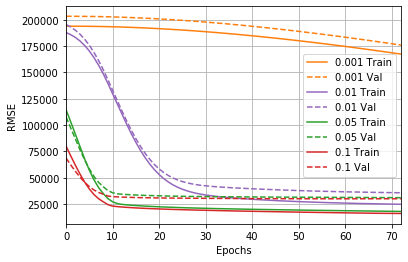

In [18]:
for lr in [0.001, 0.01, 0.05, 0.1]:
    model = simple_model(optimizer = keras.optimizers.Adam(learning_rate=lr, 
                                                                beta_1=0.9, beta_2=0.999, 
                                                                amsgrad=False))
    training_time, history = model_fit(model, f'lr/simple_adam_lr{str(lr)}')
    
    plotter.plot({str(lr): history}, metric = "root_mean_squared_error")
    plt.ylabel('RMSE')
    
    # predict
    test_predictions = model.predict(testdf_s).flatten()
    rmse = test_rmse(test_predictions) # print test set rmse.
    print('\n')
    print('*'*5 + f' Test RMSE: {rmse} '+ '*'*5)
    
    final_pred = model.predict(test_s).flatten()
    final_predictions['simple_adam_lr_'+str(lr)] = final_pred

- For our dataset, RMSprop with 0.01 learning rate is preforming better for the basic neural net.

<br>Next, let's try setting the hidden layer neuron bigger and small to see if that help our model perform better.

### Narrower/Wider Models
Recall our basic nn model (X -> 257 -> Y). Let's try other number of neurons other than 257.
<br>
Based on research, good rule of thumbs for N are: 2, (257 + 1)/ 2=129, we can also try some other numbers, 10, 50, 80, 160, 320, 500.

In [19]:
def wider_narrower_model(N, optimizer = keras.optimizers.RMSprop(0.01), 
                      dropout = False, rate = 0.15):
# inputs: 
#     N: number of neurons for the hidden layer.
#     optimizer: default: RMSprop
#     dropout: True or False (it makes sense to try dropout on the wider model.)
#     rate: default - 0.15
    set_random_seed(SEED_NUMBER) # reproducibility

    model = keras.Sequential()
    model.add(layers.Dense(N, activation='relu', input_shape=[len(traindf_s.keys())]))
    if dropout:
        model.add(layers.Dropout(rate, seed = SEED_NUMBER))
    model.add(layers.Dense(1))
    
    model.summary()
    
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    return model

<b> number of neurons in the hidden layer.

------------------------------
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 2)                 516       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 3         
Total params: 519
Trainable params: 519
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:37651519488.0000,  root_mean_squared_error:194039.9844,  val_loss:41398480556.2396,  val_root_mean_squared_error:203466.1719,  
....................................................................................................
Epoch: 100, loss:37641868250.0741,  root_mean_squared_error:194015.1250,  val_loss:41388620615.9631,  val_root_mean_squared_error:203441.9219,  
.................................................................................................

....................................................................................................
Epoch: 500, loss:699071958.5185,  root_mean_squared_error:26439.9707,  val_loss:1495176772.4240,  val_root_mean_squared_error:38667.5156,  
....................................................................................................
Epoch: 600, loss:606005688.2963,  root_mean_squared_error:24617.1836,  val_loss:1386269825.7696,  val_root_mean_squared_error:37232.6445,  
....................................................................................................
Epoch: 700, loss:572564217.4815,  root_mean_squared_error:23928.3145,  val_loss:1349980106.9124,  val_root_mean_squared_error:36742.0742,  
....................................................................................................
Epoch: 800, loss:554817214.2222,  root_mean_squared_error:23554.5586,  val_loss:1329579077.3088,  val_root_mean_squared_error:36463.3945,  
....................................


Epoch: 0, loss:37616137329.7778,  root_mean_squared_error:193948.7969,  val_loss:41306327049.4378,  val_root_mean_squared_error:203239.5625,  
....................................................................................................
Epoch: 100, loss:1014264932.7407,  root_mean_squared_error:31847.5273,  val_loss:1790605076.9401,  val_root_mean_squared_error:42315.5430,  
....................................................................................................
Epoch: 200, loss:526447403.2593,  root_mean_squared_error:22944.4414,  val_loss:1262103152.0737,  val_root_mean_squared_error:35526.0898,  
....................................................................................................
Epoch: 300, loss:463708132.1481,  root_mean_squared_error:21533.8848,  val_loss:1139166536.2581,  val_root_mean_squared_error:33751.5430,  
....................................................................................................
Epoch: 400, loss:414076365.6296


Epoch: 0, loss:37525010507.8519,  root_mean_squared_error:193713.7344,  val_loss:41049471797.0876,  val_root_mean_squared_error:202606.7031,  
....................................................................................................
Epoch: 100, loss:516561872.0000,  root_mean_squared_error:22727.9980,  val_loss:1236410984.9954,  val_root_mean_squared_error:35162.6328,  
....................................................................................................
Epoch: 200, loss:399044001.7778,  root_mean_squared_error:19976.0859,  val_loss:1035461434.9862,  val_root_mean_squared_error:32178.5859,  
....................................................................................................
Epoch: 300, loss:335280682.6667,  root_mean_squared_error:18310.6719,  val_loss:994367719.6682,  val_root_mean_squared_error:31533.5957,  
...........................................

TRAIN TIME:47 seconds 



***** Test RMSE: 17009.187770833334 *****


-------------------

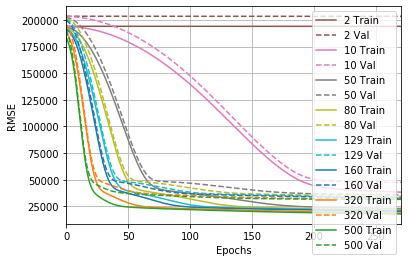

In [20]:
plt.plot(figsize=(13, 5))
for N in [2, 10, 50, 80, 129, 160, 320, 500]:
    print('-'*30)
    model = wider_narrower_model(N = N)
    training_time, history = model_fit(model, f'sizes/simple_{str(N)}')
    training_times['['+str(N)+']'] = training_time
    model_histories['['+str(N)+']'] = history
    plotter.plot({str(N): history}, metric = "root_mean_squared_error")
    plt.ylabel('RMSE')
    
    # predict
    test_predictions = model.predict(testdf_s).flatten()
    rmse = test_rmse(test_predictions) # print test set rmse.
    test_rmses['['+str(N)+']'] = rmse
    print('\n')
    print('*'*5 + f' Test RMSE: {rmse} '+ '*'*5)
    print('\n')
    
    final_pred = model.predict(test_s).flatten()
    final_predictions['simple_'+str(N)] = final_pred

- 50 has the best test_prediction rmse, with Mean Test RMSE: 16,934
How does batch size affect the results?<br><br>
<b> Batch size </b>
<br> batch size too small will converge slowly, batch size too large will result in oscillation.
As you will see in the below result, Keras default batch size of 32 is doing pretty well in our dataset.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Batch Size: 10
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 50)                12900     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 51        
Total params: 12,951
Trainable params: 12,951
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:37555600535.7037,  root_mean_squared_error:193792.6719,  val_loss:41132097989.0138,  val_root_mean_squared_error:202810.5000,  
....................................................................................................
Epoch: 100, loss:585162770.1667,  root_mean_squared_error:24190.1367,  val_loss:1486579304.8479,  val_root_mean_squared_error:38556.1836,  
..................................................


Epoch: 0, loss:37627543296.0000,  root_mean_squared_error:193978.1875,  val_loss:41336767483.2811,  val_root_mean_squared_error:203314.4531,  
....................................................................................................
Epoch: 100, loss:1244968708.4444,  root_mean_squared_error:35284.1133,  val_loss:2022136184.9217,  val_root_mean_squared_error:44968.1680,  
....................................................................................................
Epoch: 200, loss:558896308.1111,  root_mean_squared_error:23640.9863,  val_loss:1305194572.3871,  val_root_mean_squared_error:36127.4766,  
....................................................................................................
Epoch: 300, loss:500820080.6667,  root_mean_squared_error:22379.0117,  val_loss:1212541278.3779,  val_root_mean_squared_error:34821.5625,  
....................................................................................................
Epoch: 400, loss:454441052.3333

....................................................................................................
Epoch: 300, loss:528381352.7407,  root_mean_squared_error:22986.5469,  val_loss:1270654810.5438,  val_root_mean_squared_error:35646.2461,  
....................................................................................................
Epoch: 400, loss:486567378.2963,  root_mean_squared_error:22058.2734,  val_loss:1187809783.7419,  val_root_mean_squared_error:34464.6172,  
....................................................................................................
Epoch: 500, loss:453929107.3333,  root_mean_squared_error:21305.6133,  val_loss:1122459286.7834,  val_root_mean_squared_error:33503.1250,  
....................................................................................................
Epoch: 600, loss:424288662.6667,  root_mean_squared_error:20598.2695,  val_loss:1077645423.1889,  val_root_mean_squared_error:32827.5078,  
....................................

....................................................................................................
Epoch: 300, loss:1296459540.1481,  root_mean_squared_error:36006.3828,  val_loss:2083216558.5991,  val_root_mean_squared_error:45642.2656,  
....................................................................................................
Epoch: 400, loss:762227744.0000,  root_mean_squared_error:27608.4707,  val_loss:1559659957.0876,  val_root_mean_squared_error:39492.5312,  
....................................................................................................
Epoch: 500, loss:585427018.3704,  root_mean_squared_error:24195.5996,  val_loss:1358325712.5161,  val_root_mean_squared_error:36855.4688,  
....................................................................................................
Epoch: 600, loss:538470552.5926,  root_mean_squared_error:23204.9668,  val_loss:1289060223.2627,  val_root_mean_squared_error:35903.4844,  
...................................

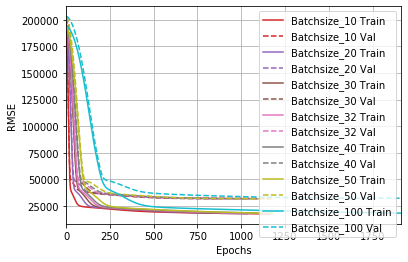

In [21]:
# try different batch size.
N = 50
for bs in [10, 20, 30, 32, 40, 50, 100]:
    print('- '*30)
    print(f'Batch Size: {bs}')
    model = wider_narrower_model(N = N)
    training_time, history = model_fit(model, f'batchsize/simple_{str(N)}_bs{bs}', batchsize = bs)
    
    plotter.plot({'batchsize_'+str(bs): history}, metric = "root_mean_squared_error")
    plt.ylabel('RMSE')
    
    test_predictions = model.predict(testdf_s).flatten() # predict
    rmse = test_rmse(test_predictions) 
    print('\n')
    print('*'*5 + f' Test RMSE: {rmse} '+ '*'*5)
    print('\n')
    
    final_pred = model.predict(test_s).flatten()
    final_predictions['simple_50_bs'+str(bs)] = final_pred

So far we've only built simple NN with 1 hidden layer.
<br>
Let's try deeper NN with more hidden layers to see if they perform better than the simple NN.

### Deeper Models
X -> N -> N -> N -> Y

In [22]:
def deeper_model(L, N, optimizer = keras.optimizers.RMSprop(0.01),
                       dropout = False, rate = 0.15):
    
#     inputs: 
#         L: integer, number of hidden layers.
#         N: list (integer), list of neurons in each hidden layers. len(N) == L
#         dropout: True or False, model will only drop node in layers where number of neuron is >= 50.
#         rate: float. Dropout rate. ranges between 0 to 1.

    
    # check inputs
    if len(N) != L:
        raise ValueError('length of N is not equal to L')
        
    set_random_seed(SEED_NUMBER) # reproducibility
    model = keras.Sequential()
    model.add(layers.Dense(N[0], activation='relu', input_shape=[len(traindf_s.keys())]))
    if dropout:
        if N[0]>=50:
            model.add(layers.Dropout(rate, seed=SEED_NUMBER))
    for i in range(1,L): # first layer is already added
        model.add(layers.Dense(N[i], activation='relu'))
        if dropout: 
            if N[i]>=50:
                model.add(layers.Dropout(rate, seed=SEED_NUMBER))
    model.add(layers.Dense(1)) # final layer
    
    model.summary()
    
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    return model

In [23]:
try_hidden_layers = [2, 3, 3, 3, 4, 5]
try_neuron_size = [[500,2],[500,2,2],[32,32,32],[64, 64, 64],[256,128,64,32],[10,10,10,10,10]]

plt.figure(figsize=(13,5))
for L, N in zip(try_hidden_layers,try_neuron_size):

    print('- '*30)
    model = deeper_model(L, N)
    training_time, history = model_fit(model, 'sizes/deep_'+str(N))
    training_times['deep_'+str(N)] = training_time
    model_histories['deep_'+str(N)] = history
    
    test_predictions = model.predict(testdf_s).flatten() # predict
    rmse = test_rmse(test_predictions) 
    test_rmses['deep_'+str(N)] = rmse
    print('\n')
    print('*'*5 + f' Test RMSE: {rmse} '+ '*'*5) 
    print('\n')
    
    final_pred = model.predict(test_s).flatten()
    final_predictions['deep_'+str(N)] = final_pred

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 500)               129000    
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 1002      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 3         
Total params: 130,005
Trainable params: 130,005
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:37491362550.5185,  root_mean_squared_error:193626.8750,  val_loss:40842877107.3180,  val_root_mean_squared_error:202096.2031,  
....................................................................................................
Epoch: 100, loss:369889714.3704,  root_mean_squared_error:19232.5156,  


Epoch: 0, loss:12253142414.2222,  root_mean_squared_error:110693.9141,  val_loss:1663588557.2719,  val_root_mean_squared_error:40787.1133,  
..................................

TRAIN TIME:7 seconds 



***** Test RMSE: 18322.4133125 *****


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 10)                2580      
_________________________________________________________________
dense_69 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_70 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_71 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_72 (Dens

<Figure size 936x360 with 0 Axes>

In [24]:
# try different early stopping
L = 2
N = [500,2]

for p in range(5,25):
    
    print('- '*30)
    print(f'Early Stopping Patience: {p}')
    model = deeper_model(L, N)
    
    training_time, history = model_fit(model, 'patience/'+str(p), patience = p) #fit
    training_times['deep_patience_'+str(p)] = training_time
    model_histories['deep_patience_'+str(p)] = history
    
    test_predictions = model.predict(testdf_s).flatten() # predict
    rmse = test_rmse(test_predictions) 
    test_rmses['deep_patience_'+str(p)] = rmse
    print('\n')
    print('*'*5 + f' Test RMSE: {rmse} '+ '*'*5) 
    print('\n')
    

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Early Stopping Patience: 5
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 500)               129000    
_________________________________________________________________
dense_75 (Dense)             (None, 2)                 1002      
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 3         
Total params: 130,005
Trainable params: 130,005
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:37491362550.5185,  root_mean_squared_error:193626.8750,  val_loss:40842877390.4516,  val_root_mean_squared_error:202096.2031,  
....................................................................................................
Epoch: 100, loss:369889714.3704,  root_mean_

.....................................................

TRAIN TIME:25 seconds 



***** Test RMSE: 16790.093208333332 *****


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Early Stopping Patience: 10
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 500)               129000    
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 1002      
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 3         
Total params: 130,005
Trainable params: 130,005
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:37491362550.5185,  root_mean_squared_error:193626.8750,  val_loss:40842878692.8664,  val_root_mean_squared_error:202096.2188,  
...................

....................................................................................................
Epoch: 100, loss:369889714.3704,  root_mean_squared_error:19232.5156,  val_loss:998340789.6774,  val_root_mean_squared_error:31596.5293,  
..........................................................

TRAIN TIME:29 seconds 



***** Test RMSE: 16803.9446875 *****


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Early Stopping Patience: 15
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 500)               129000    
_________________________________________________________________
dense_105 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 3         
Total params: 130,005
Trainable params: 130,005
Non-trainable


Epoch: 0, loss:37491362550.5185,  root_mean_squared_error:193626.8750,  val_loss:40842877975.5945,  val_root_mean_squared_error:202096.2031,  
....................................................................................................
Epoch: 100, loss:369889714.3704,  root_mean_squared_error:19232.5156,  val_loss:998340805.0138,  val_root_mean_squared_error:31596.5312,  
...............................................................

TRAIN TIME:28 seconds 



***** Test RMSE: 16821.948020833333 *****


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Early Stopping Patience: 20
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 500)               129000    
_________________________________________________________________
dense_120 (Dense)            (None, 2)                 1002      
_______________________________________


Epoch: 0, loss:37491362550.5185,  root_mean_squared_error:193626.8750,  val_loss:40842879051.5023,  val_root_mean_squared_error:202096.2031,  
....................................................................................................
Epoch: 100, loss:369889714.3704,  root_mean_squared_error:19232.5156,  val_loss:998340790.2673,  val_root_mean_squared_error:31596.5332,  
....................................................................

TRAIN TIME:29 seconds 



***** Test RMSE: 16839.818854166668 *****




Early stopping = 5 epochs gives us best result for X->500->2->Y. With test RMSE = 16784.

### Deep NN w/ dropout
dropout is helpful regularization method for deeper neural nets that helps with overfitting problem.

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 500)               129000    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 2)                 1002      
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 3         
Total params: 130,005
Trainable params: 130,005
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 500)               129000    
________________________


Epoch: 0, loss:35603578538.6667,  root_mean_squared_error:188689.1094,  val_loss:31681313164.3871,  val_root_mean_squared_error:177992.4531,  
...................................................................................

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
hidden layers: 3, number of neurons:[32, 32, 32] 

TRAIN TIME:7 seconds 

375/375 - 0s - loss: 691071126.7840 - root_mean_squared_error: 26288.2344
Validation set Root Mean Squared Error: 26288.23


***** Test RMSE: 17755.941979166666 *****


Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 64)                16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_146 (Dense)           

375/375 - 0s - loss: 943541430.1013 - root_mean_squared_error: 30717.1191
Validation set Root Mean Squared Error: 30717.12


***** Test RMSE: 23351.104895833334 *****


Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 64)                16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_155 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_156 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_10 (Drop

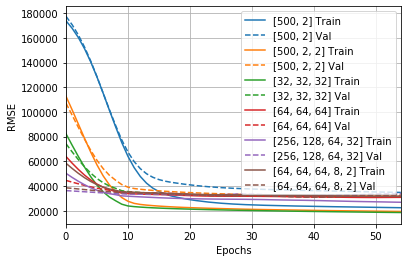

In [26]:
try_hidden_layers = [2, 3, 3, 3, 4, 5]
try_neuron_size = [[500,2],[500,2,2],[32,32,32],[64, 64, 64],[256,128,64,32], [64,64,64,8,2]]

for L, N in zip(try_hidden_layers,try_neuron_size):
    model = deeper_model(L, N, dropout = True, rate = 0.1)
    print(model.summary())
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience = 15)
    set_random_seed(SEED_NUMBER) # reproducibility
    start_time = time.time()
    model_history = model.fit(traindf_s, train_labels, shuffle = False,
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size = 35,
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    print('\n')
    print('- '*40)
    print(f'hidden layers: {L}, number of neurons:{N} \n')
    print('TRAIN TIME:'+f'{round(time.time()-start_time)}'+' seconds \n')
    loss, rmse = model.evaluate(testdf_s, test_labels, verbose=2)
    print("Validation set Root Mean Squared Error: {:5.2f}".format(rmse))

    plotter.plot({str(N): model_history}, metric = "root_mean_squared_error") 
    plt.ylabel('RMSE')

    test_predictions = model.predict(testdf_s).flatten() # predict
    rmse = test_rmse(test_predictions)
    print('\n')
    print('*'*5 + f' Test RMSE: {rmse} '+ '*'*5) 
    print('\n')
    
    final_pred = model.predict(test_s).flatten()
    final_predictions['deep_w_do_'+str(N)] = final_pred


In [27]:
df = pd.DataFrame.from_dict(final_predictions).iloc[:,9:25]
test_raw = pd.read_csv('./data/raw/test.csv')
# pred = pd.DataFrame(final_pred, columns=['SalePrice'])
ID = test_raw[['Id']]
# sub=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
# sub.to_csv('500_2_prediction.csv',index=False)
for i in range(7):
    pred = df.iloc[:,i]
    name = df.columns[i]
    sub=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
    sub.columns = ['ID','SalePrice']
    sub.to_csv(name+'_pred.csv', index=False)